# Classification: Logistic Regression, SVM and MLP

**What to do:**

Apply some of the ML algorithms we have discussed in the JClub presentations to the data given.

**Goal:** 

Train a classifier with maximum accuracy measured as Correctly Classified Instances percentage (C.C.I.%) using 10-fold cross-validation

## Setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.io import arff


from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import (
    KFold,
    cross_val_score,
    train_test_split
)
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.svm import SVC

## Loading Data

In [2]:
data = arff.loadarff('./assets/arff/genre.arff')
df = pd.DataFrame(data[0])

df.head()
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Columns: 241 entries, highlevel_danceability_value to genre
dtypes: float64(237), object(4)
memory usage: 1.5+ MB


## Preprocessing
Converting feature type and scaling values to be usable by the model

In [3]:
y = df['genre']
unique_genres = y.unique()
print('Unique genres labels:', unique_genres)
print('Number of unique genres:', len(unique_genres))

X = df.drop(['genre'], axis=1)
print('Number of features:', len(X.columns))

Unique genres labels: [b'blu' b'cla' b'cou' b'dis' b'hip' b'jaz' b'met' b'pop' b'reg' b'roc']
Number of unique genres: 10
Number of features: 240


In [4]:
# Split the data into numerical and categorical features
categorical_features = X.select_dtypes(include='object')
numeric_features = X.select_dtypes(include='float64')

# Define the column transformers
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude="object")),
        ("cat", categorical_transformer, selector(dtype_include="object")),
    ]
)

label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y)
label_encoder_name_mapping = dict(zip(label_encoder.classes_,
                                         label_encoder.fit_transform(label_encoder.classes_)))
print("Mapping of Label Encoded Classes", label_encoder_name_mapping, sep="\n")
# print("Label Encoded Target Variable", encoded_y, sep="\n")

Mapping of Label Encoded Classes
{b'blu': 0, b'cla': 1, b'cou': 2, b'dis': 3, b'hip': 4, b'jaz': 5, b'met': 6, b'pop': 7, b'reg': 8, b'roc': 9}


## Logistic Regression

In [5]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", LogisticRegression(max_iter=1000))]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, encoded_y, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)
scores = cross_val_score(clf, X, encoded_y, cv=10)

scores_mean = scores.mean() * 100 
scores_std = scores.std() * 100

print(f"{scores_mean} % accuracy with a standard deviation of {scores_std} %")

81.37500000000001 % accuracy with a standard deviation of 5.137180647008628 %


In [6]:
# Get the feature names from the preprocessor
num_names = clf.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()
cat_names = clf.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out()

feature_names = np.concatenate([num_names, cat_names])

# Get the coefficients from the classifier
coef = clf.named_steps['classifier'].coef_

# Create a pandas dataframe with the feature names and coefficients
coef_df = pd.DataFrame({"feature": feature_names, "coef": coef[0]})

# Sort the dataframe by absolute value of coefficients to get most important features
coef_df["abs_coef"] = np.abs(coef_df["coef"])
coef_df = coef_df.sort_values("abs_coef", ascending=False)

# Print the top 10 most important features
print("Top 10 most important features for Logistic Regression:")
print(coef_df.head(10))

Top 10 most important features for Logistic Regression:
                               feature      coef  abs_coef
10          loudness_replay_gain_value -1.087576  1.087576
85          spectral_barkbands_21_mean  0.722928  0.722928
123  spectral_energybandratio_low_dvar  0.556914  0.556914
151              spectral_mfcc_02_mean  0.541050  0.541050
13                 loudness_vicker_var -0.536726  0.536726
133          spectral_flatness_db_mean  0.510648  0.510648
45          spectral_barkbands_08_dvar  0.437474  0.437474
145              spectral_mfcc_00_mean -0.415317  0.415317
163              spectral_mfcc_06_mean -0.412164  0.412164
165              spectral_mfcc_07_dvar  0.398216  0.398216


## SVM with KFold cross-validation

In [7]:
# Building the pipeline
clf = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", SVC(kernel='linear', C=1))]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, encoded_y, test_size=0.2, random_state=0)

# Initialize a k-fold cross-validation splitter
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

scores = []

kf.get_n_splits(X)
for i, (train_index, test_index) in enumerate(kf.split(X)):
    clf.fit(X_train, y_train)
    
    score = cross_val_score(clf, X, encoded_y, cv=10)
    scores.append(score)

scores_mean = np.mean(scores) * 100
scores_std = np.std(scores) * 100 

print(f"{scores_mean} % accuracy with a standard deviation of {scores_std} %")

81.24999999999996 % accuracy with a standard deviation of 4.031128874149275 %


In [8]:
# Get the coefficients from the classifier
coef = clf.named_steps['classifier'].coef_

# Create a pandas dataframe with the feature names and coefficients
coef_df = pd.DataFrame({"feature": feature_names, "coef": coef[0]})

# Sort the dataframe by absolute value of coefficients to get most important features
coef_df["abs_coef"] = np.abs(coef_df["coef"])
coef_df = coef_df.sort_values("abs_coef", ascending=False)

# Print the top 10 most important features
print("Top 10 most important features for SVM classifier:")
print(coef_df.head(10))

Top 10 most important features for SVM classifier:
                                         feature      coef  abs_coef
152                         spectral_mfcc_02_var  0.134389  0.134389
10                    loudness_replay_gain_value -0.106125  0.106125
45                    spectral_barkbands_08_dvar  0.080984  0.080984
146                         spectral_mfcc_00_var -0.078340  0.078340
186  spectral_pitch_instantaneous_confidence_var  0.074228  0.074228
123            spectral_energybandratio_low_dvar  0.073959  0.073959
170                         spectral_mfcc_08_var -0.071841  0.071841
218                  tempotap_bpm_estimates_mean -0.070470  0.070470
11                          loudness_vicker_dvar  0.069810  0.069810
228               tonal_chords_number_rate_value -0.067167  0.067167


## MLP Classifier

In [9]:
# Check the shape of the data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((640, 240), (160, 240), (640,), (160,))

### First Implementation with `accuracy_score`

In [10]:
# Define the model
model = MLPClassifier(hidden_layer_sizes=(64,32), 
                      max_iter=600, 
                      solver='adam', 
                      activation='relu', 
                      random_state=0)

# Define the pipeline
clf = Pipeline(
    steps=[("preprocessor", preprocessor),
              ("classifier", model)]
)

# Initialize a k-fold cross-validation splitter
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)
acc_score = []

# Iterate through the splits
for train, test in kf.split(X, encoded_y):
    X_train, X_test, y_train, y_test = X.iloc[train], X.iloc[test], encoded_y[train], encoded_y[test]
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_pred, y_test)
    acc_score.append(acc)

avg_acc_score = sum(acc_score)/k
 
print('C.C.I. of each fold: {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

C.C.I. of each fold: [0.825, 0.8, 0.8625, 0.8, 0.775, 0.8375, 0.8, 0.8, 0.825, 0.8125]
Avg accuracy : 0.81375


In [11]:
# Get the coefficients from the classifier
coef = clf.named_steps['classifier'].coefs_[0]
coef_squeeze = np.resize(coef, (240, ))

# Create a pandas dataframe with the feature names and coefficients
coef_df = pd.DataFrame({"feature": feature_names, "coef": coef_squeeze})

# Sort the dataframe by absolute value of coefficients to get most important features
coef_df["abs_coef"] = np.abs(coef_df["coef"])
coef_df = coef_df.sort_values("abs_coef", ascending=False)

# Print the top 10 most important features
print("Top 10 most important features for MLP classifier:")
print(coef_df.head(10))

Top 10 most important features for MLP classifier:
                               feature      coef  abs_coef
20             rhythm_onset_rate_value  0.230701  0.230701
173               spectral_mfcc_09_var -0.225328  0.225328
19           rhythm_beats_loudness_var  0.207986  0.207986
146               spectral_mfcc_00_var -0.207827  0.207827
233              tonal_dissonance_mean -0.203154  0.203154
82          spectral_barkbands_20_mean -0.201237  0.201237
149               spectral_mfcc_01_var  0.197978  0.197978
164               spectral_mfcc_06_var  0.191513  0.191513
152               spectral_mfcc_02_var -0.191327  0.191327
122  spectral_energybandratio_high_var  0.189158  0.189158


### Second Implementation using `cross_val_scores` and `precision_score`

We get the same results as in the previous one,using a different score function.

In [12]:
model = MLPClassifier(hidden_layer_sizes=(64,32), 
                      max_iter=600, 
                      solver='adam', 
                      activation='relu', 
                      random_state=0)

clf = Pipeline(
    steps=[("preprocessor", preprocessor),
              ("classifier", model)]
)

# Initialize a k-fold cross-validation splitter
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

result = cross_val_score(clf, X, encoded_y, cv=kf)
precision = precision_score(y_test, y_pred, average='weighted')

print("Mean C.C.I.: {}".format(result.mean()))
print("Standard Deviation of C.C.I.: {}".format(result.std()))
print("Precision Score: {}".format(precision))

Mean C.C.I.: 0.81375
Standard Deviation of C.C.I.: 0.023351927115336752
Precision Score: 0.809389880952381


In [13]:
# Get the coefficients from the classifier
coef = clf.named_steps['classifier'].coefs_[0]
coef_squeeze = np.resize(coef, (240, ))

# Create a pandas dataframe with the feature names and coefficients
coef_df = pd.DataFrame({"feature": feature_names, "coef": coef_squeeze})

# Sort the dataframe by absolute value of coefficients to get most important features
coef_df["abs_coef"] = np.abs(coef_df["coef"])
coef_df = coef_df.sort_values("abs_coef", ascending=False)

# Print the top 10 most important features
print("Top 10 most important features for MLP classifier:")
print(coef_df.head(10))

Top 10 most important features for MLP classifier:
                               feature      coef  abs_coef
20             rhythm_onset_rate_value  0.230701  0.230701
173               spectral_mfcc_09_var -0.225328  0.225328
19           rhythm_beats_loudness_var  0.207986  0.207986
146               spectral_mfcc_00_var -0.207827  0.207827
233              tonal_dissonance_mean -0.203154  0.203154
82          spectral_barkbands_20_mean -0.201237  0.201237
149               spectral_mfcc_01_var  0.197978  0.197978
164               spectral_mfcc_06_var  0.191513  0.191513
152               spectral_mfcc_02_var -0.191327  0.191327
122  spectral_energybandratio_high_var  0.189158  0.189158


/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


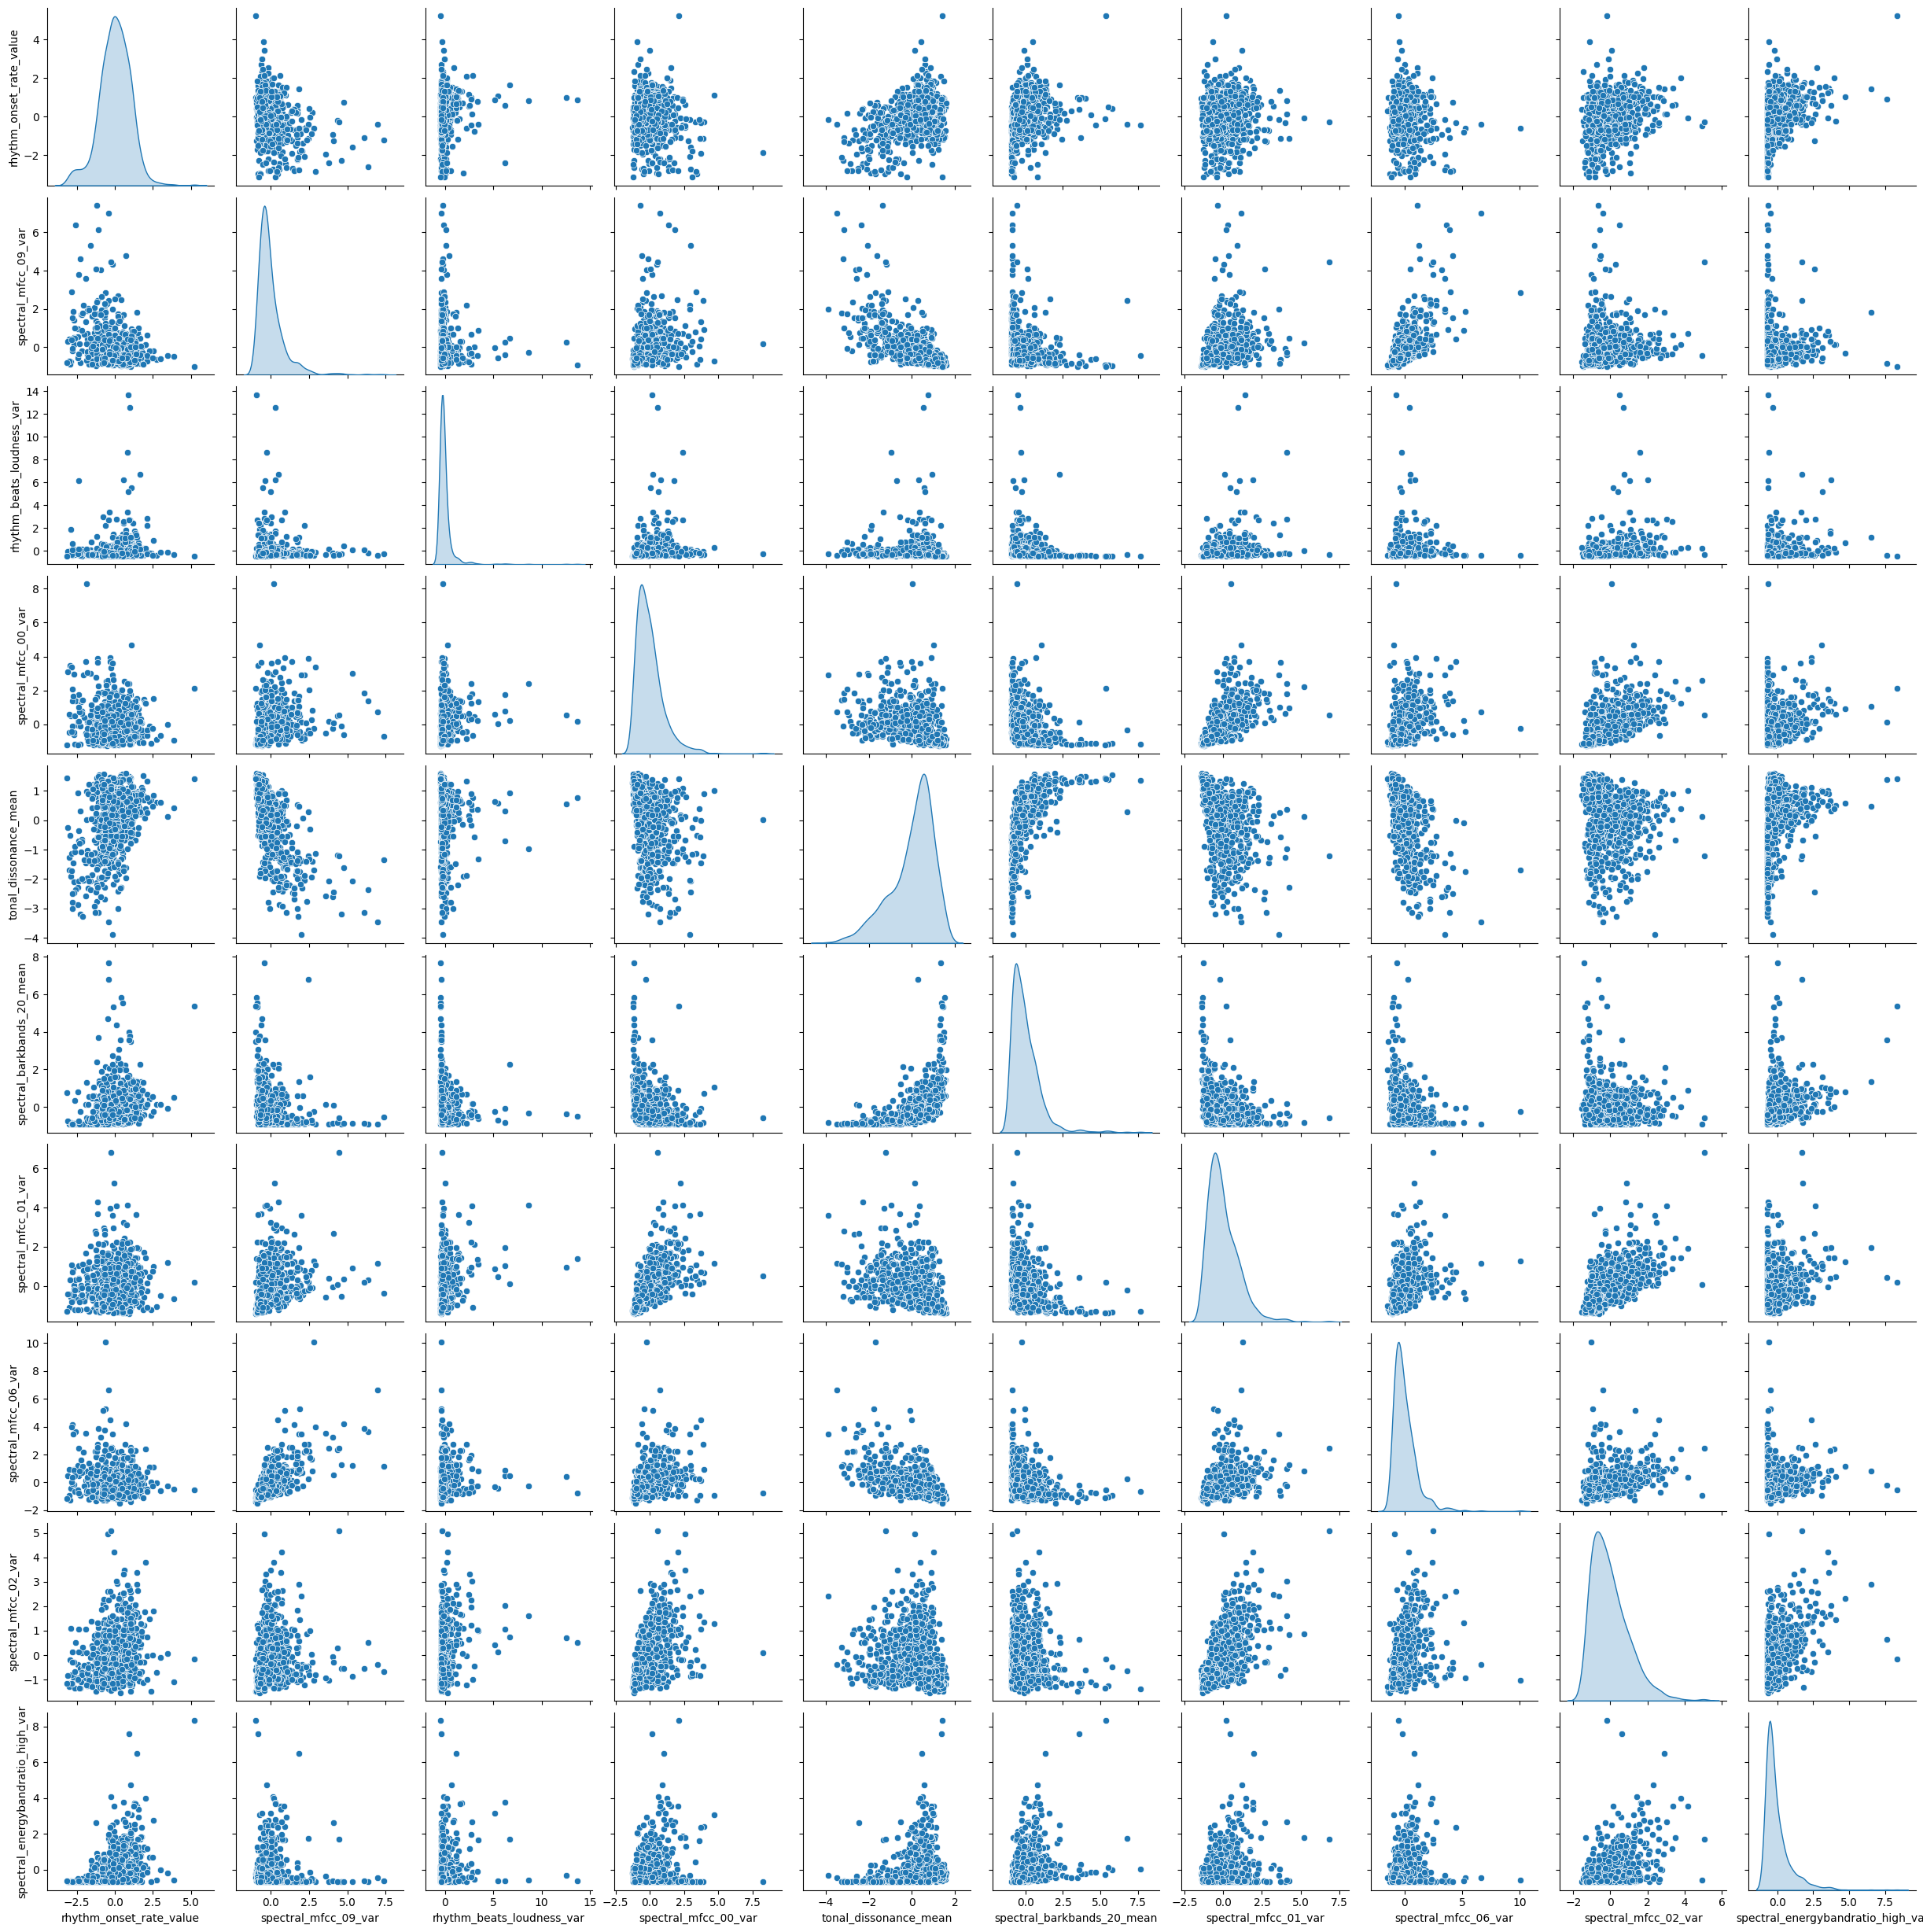

In [14]:
sns.pairplot(df[['rhythm_onset_rate_value', 
               'spectral_mfcc_09_var', 
               'rhythm_beats_loudness_var',
               'spectral_mfcc_00_var',
               'tonal_dissonance_mean',
               'spectral_barkbands_20_mean',
                'spectral_mfcc_01_var',
                'spectral_mfcc_06_var',
                'spectral_mfcc_02_var',
                'spectral_energybandratio_high_var']], diag_kind='kde')